# Task I

Shapely is a python package that relies on the same geometry engine (GEOS) as does PostGIS. It is designed for shorter-term analysis, when the management of a large relational database is not part of your intentions. It is often quicker to use for ad-hoc spatial analyses, does not depend on the (somtimes complicated) creation of the highly structured RDBMS, and relies on python idioms that can be more familiar and easier to work with than those of the SQL/GIS world. It handles operations on *geometries* (points, curves, and surfaces), but not *geographies* (in the PostGIS data type sense). It would not be suitable for spatial calculations in which your data is highly spatially distributed and you need to take into account the spheroid shape of the Earth. Since it relies on the same C++ engine (GEOS), I expect the performance to be similar to that of PostGIS. However, the documentation notes that there is some overhead associated with creating geometries involving many coordinates. There is a "shapely.speedups" module that seems to help with this, but very little information on how this module is implemented.

PostGIS, on the other hand, is a RDBMS. It relies on SQL to query data and offers the same geometric manipulation tools that Shapely does. In addition, it allows the possibility of associating your data with spherical (lat/long) coordinates. While shapely works entirely in cartesian coordinate systems and does not involve any geographic projections, PostGIS allows more rigorous geospatial analysis across the globe. It is the better choice if you are managing a database over a longer timeframe and will need to query it multiple times in numerous different ways. It is also a better choice if your data is highly spatially distributed (because of it's spherical representation capabilities). It is likely also faster for spatial relational queries of large size due to spatial indexing of the database. Because it is often time-consuming to set up and requires a specific data format, it is likely not the best choice for short, ad-hoc spatial analyses.

Fiona is a python package used for reading and writing data files, and it is often used in combination with a tool like shapely. It is useful when you want to turn an arbitrary data type (for instance a CSV with lat/long columns) into spatial data and to convert between spatial data formats.

**In summary**: For ad-hoc spatial analysis of relatively small datasets, the Fiona/Shapely combination is probably the easiest way to go. For longer-term projects with spatial data that will require database management over time and/or analysis of large amounts of data across large geographic scales, inserting your data into a PostGIS database and relying on SQL queries is probably the way to go

# Task II

In [6]:
# Imports and settings
import psycopg2
import numpy as np
import pandas as pd
import datetime
from os.path import join
import csv
from IPython.display import Image,Latex
from sklearn.cluster import KMeans,DBSCAN
from pyproj import Proj
import geojson
import geopandas
import shapely as shp

# Turn off annoything SettingWithCopy warnings
pd.set_option('mode.chained_assignment',None)

# SRID for geographic CS (for importing from lat/long)
SRID_geog = 4326

# SRID for projection CS (UTM Zone in Northern Cal)
SRID_proj = 32610

# random seed
seed = 1234

# set filepaths
data_loc = u"""/Users/ianbolliger/Box Sync/grad_school/courses/2015_fall\
/spatial_analytics/assignments/assignment_2"""

#### Verify working PostGIS and spatially-enabled database

In [3]:
conn = psycopg2.connect("dbname=template_postgis host=localhost")
cur = conn.cursor()
cur.execute("""SELECT srtext FROM spatial_ref_sys WHERE srid = 32610""")
rows = cur.fetchall()
print rows[0]
cur.close()
conn.close()

('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],AUTHORITY["EPSG","32610"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',)


## 1) Create database

In [ ]:
> psql
$ CREATE DATABASE assignment_2 OWNER bolliger TEMPLATE template_postgis ENCODING 'utf8';
$ \connect assignment_2
$ CREATE TABLE tweets (
        id bigint,
        userid integer,
        loc geometry,
        time timestamptz,
        text text);

## 2)  Parse tweets coordinates

In [7]:
# load data
tweets = pd.read_json(join(data_loc,'tweets_1M.json'))

# select 100k subset of tweets
n_subset = 100000
subset = tweets.sample(n=n_subset, random_state=seed)

# parse dates
subset['time'] = pd.to_datetime(subset['timeStamp'])

# fix lat/lng format
subset['loc']="SRID=" + str(SRID_geog) + ";POINT(" + subset['lng'].astype('string') + ' ' + subset['lat'].astype('string') + ")"

# keep necessary columns
subset=subset.reindex(columns=['id','user_id','loc','time','text'])

## 3) Insert 100K tweets into PostGIS table

In [94]:
# connect to database
conn = psycopg2.connect("dbname=assignment_2 host=localhost")
cur = conn.cursor()

In [ ]:
# save as CSV for COPY FROM
subset.to_csv(join(data_loc,'tweets.csv'),index=False, encoding='utf8',quoting=csv.QUOTE_NONNUMERIC)

# COPY to postGIS table (could only figure out how to copy if SRID=4326)
cur.execute("COPY tweets FROM %s DELIMITER ',' CSV HEADER", (join(data_loc,"tweets.csv"),))

# Transform to UTM projection (needed for distance calcs in meters)
cur.execute("""ALTER TABLE tweets
                ALTER COLUMN loc TYPE geometry(POINT,%s) USING ST_Transform(loc,%s)""", (SRID_proj,SRID_proj))
conn.commit()

## 5) Convert shapefile into suitable form for database and insert

In [ ]:
> shp2pgsql -I -W "latin1" -s 4326:32610 tl_2010_06_county10.shp public.ca_census_tract | psql -d assignment_2

## 6) Calculate number of tweets inside Contra Costa County

In [95]:
cur.execute("""SELECT COUNT(*) from tweets t,ca_census_tract ct
    WHERE 
        ct.name10 = 'Contra Costa'
    AND
        ST_CONTAINS(ct.geom,t.loc)""")
tweets_in_CoCo = cur.fetchone()
print "tweets from 100K subset that fall within Contra Costa County:", tweets_in_CoCo[0]

tweets from 100K subset that fall within Contra Costa County: 8563


## 7) Calculate number of tweets 100 miles outside Alameda County

In [96]:
# 100 miles = 160934 meters

cur.execute("""SELECT COUNT(*) FROM tweets t, ca_census_tract ct
    WHERE
        ct.name10 = 'Alameda'
    AND NOT
        ST_DWITHIN(t.loc,ct.geom,160934)""")
tweets_outside_AC = cur.fetchone()
print "tweets from 100K subset that fall 100 miles outside of Alameda County:", tweets_outside_AC[0]

tweets from 100K subset that fall 100 miles outside of Alameda County: 14705


## 8) Insert 2010 Census pop per county into database

In [ ]:
> psql assignment_2
$ CREATE TABLE ca_census_data
    (GEOID varchar(11),
    SUMLEV varchar(3),
    STATE varchar(2),
    COUNTY varchar(3),
    CBSA varchar(5),
    CSA varchar(3),
    NECTA integer,
    CNECTA integer,
    NAME varchar(30),
    POP100 integer,
    HU100 integer,
    POP1002000 integer,
    HU1002000 integer,
    P001001 integer,
    P0010012000 integer);
$ COPY ca_census_data FROM '/Users/ianbolliger/Box Sync/grad_school/courses/2015_fall/spatial_analytics/assignments/assignment_2' CSV HEADER;

## 9) Provide visualization of tweets per-capita 

In [ ]:
cur.execute("""CREATE TABLE tweets_pc AS

WITH n_tweets as (
SELECT ct.name10,ct.countyfp10,COUNT(t.loc) as tweets_per_county,ct.geom
    FROM tweets t
    RIGHT JOIN ca_census_tract ct
        ON ST_CONTAINS(ct.geom,t.loc)
    GROUP BY ct.countyfp10,ct.name10,ct.geom)


SELECT n_tweets.name10,n_tweets.tweets_per_county/cd.pop100::float as tweets_per_capita,n_tweets.geom
    FROM n_tweets
    INNER JOIN ca_census_data as cd
        ON cd.county = n_tweets.countyfp10""")
conn.commit()

The following visualization was constructed in QGIS from the "tweets_pc" table constructed above

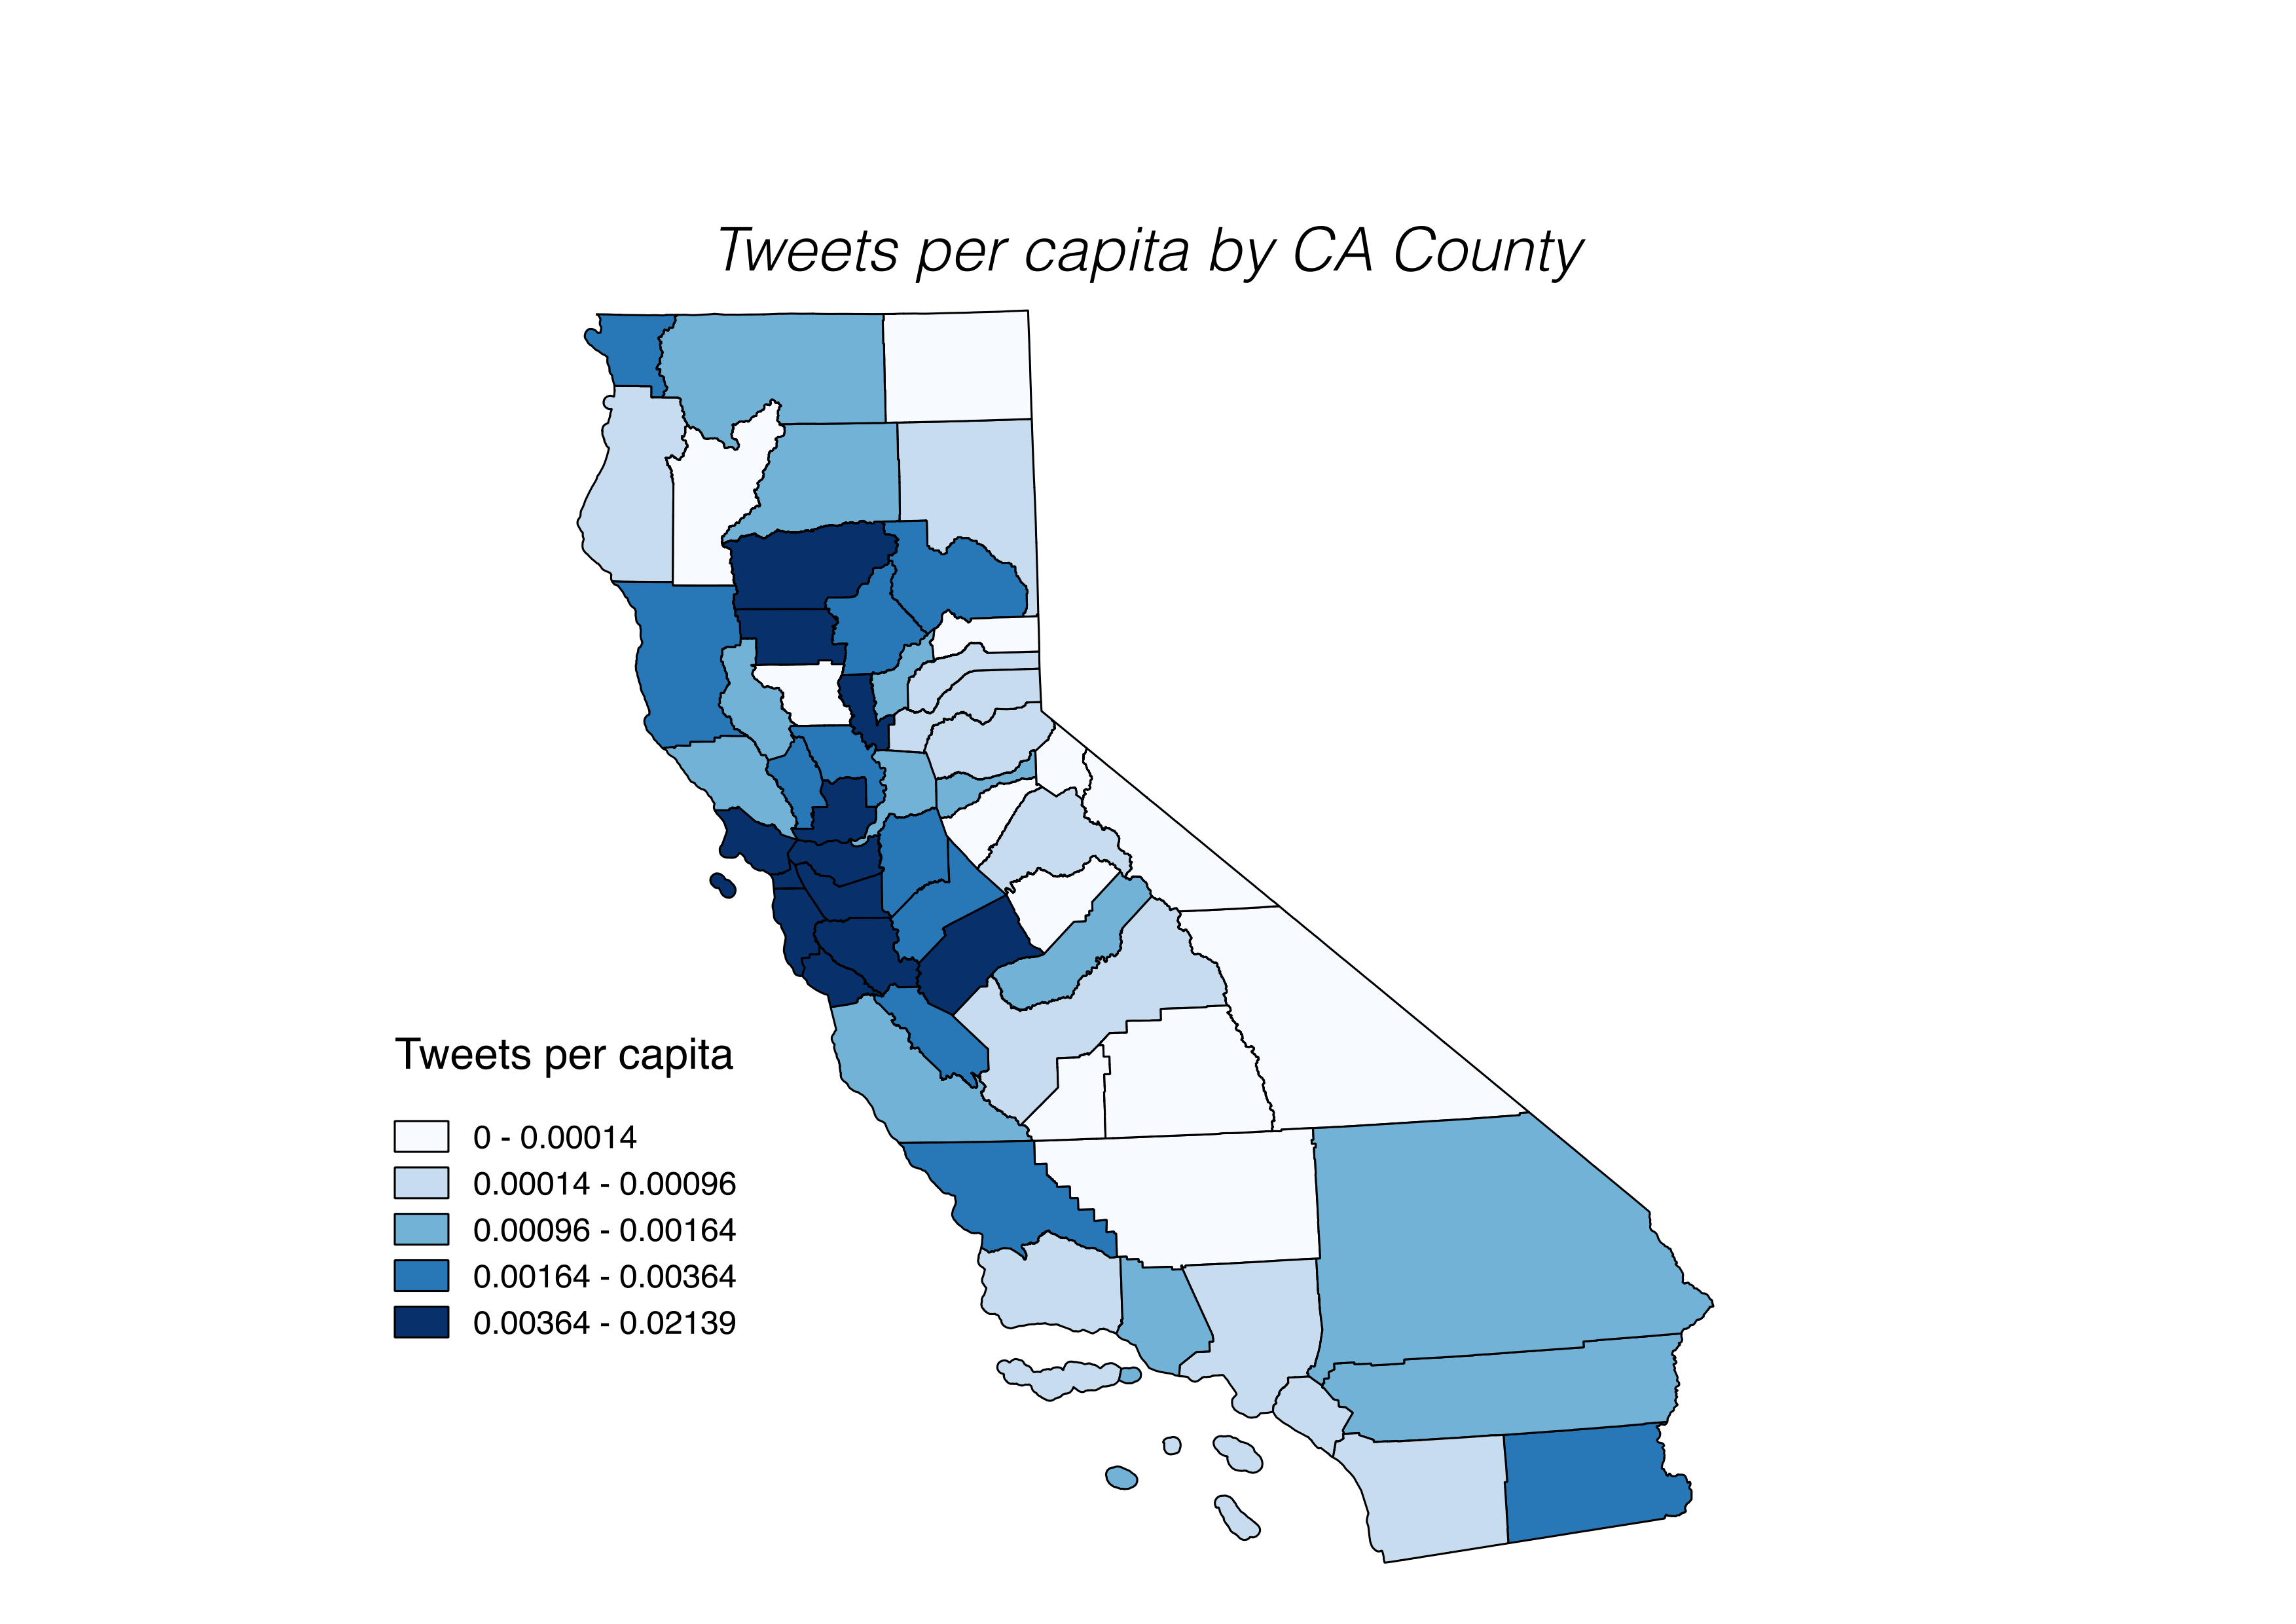

In [97]:
Image(join(data_loc,'tpc.png'))

## 10) Find radii of DBSCAN tweet clusters

In [8]:
# Take 10k sample of tweets
subset_10 = tweets.sample(n=10000, random_state=seed)

# Project into UTM system
myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84")
UTMx,UTMy = myProj(subset_10['lng'].values,subset_10['lat'].values)
subset_10['m_N'] = UTMy
subset_10['m_E'] = UTMx
coords = subset_10[['m_N','m_E']]

# Run DBSCAN
eps = 1000 #meters
min_samples = 10

db = DBSCAN(eps=eps, min_samples=min_samples)
coords['labels'] = db.fit_predict(coords)

# keep non-outliered points
coords = coords[coords['labels'] != -1]

# count number of non-outlier points
n = np.count_nonzero(db.labels_ + 1)
print "non-outliers:", n

# count number of clusters
n_clust = len(set(coords['labels']))
print "number of clusters:", n_clust

non-outliers: 7112
number of clusters: 130


In [99]:
# find centroids
grouped = coords.groupby('labels')
centroids = grouped.mean()
counts = grouped['m_N'].count()
dists = coords.join(centroids,on='labels',rsuffix='_centroid').join(counts,on='labels',rsuffix='count')
dists.rename(columns={'m_Ncount':'n_tweets'})

# calc distance
dists['dist'] = np.sqrt((dists['m_N']-dists['m_N_centroid'])**2 + (dists['m_E']-dists['m_E_centroid'])**2)
dists.head()

# calc min radius and total tweets for each cluster
grouped = dists[['labels','dist']].groupby('labels')
rad = grouped.max().rename(columns={'dist':'Minimum Radius (m)'})
n_tweets = grouped.count().rename(columns={'dist':'# Tweets'})

# show table
tab = rad.join(n_tweets).sort('Minimum Radius (m)',ascending=False)
tab.index.name = 'Cluster ID'
tab

,Minimum Radius (m),# Tweets
Cluster ID,,
5,15677.547659,1855
7,12611.359454,741
9,9366.779802,491
10,7168.443022,291
2,6916.984122,374
19,4171.985760,120
6,3807.824169,133
15,3669.997566,60
22,3281.394015,56


# Task III

In [9]:
# Connect to MongoDB Instance and set up database and collection
from pymongo import MongoClient
import pymongo
mongo_client = MongoClient()
mongo_db = mongo_client.san_francisco_db
tweets_col = mongo_db.tweets


In [5]:
## cluster using 2-step algorithm from HW1

# Project into UTM system
myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84")
UTMx,UTMy = myProj(tweets['lng'].values,tweets['lat'].values)
coords = pd.DataFrame({'m_E':UTMx,'m_N':UTMy})
tweets['m_N'] = UTMy
tweets['m_E'] = UTMx
coords = tweets[['m_N','m_E']]

# parameters
k1 = 2
e = 100 # 100 meter epsilon
min_samples = 100

# initialize algorithms object
km = KMeans(init='k-means++', n_clusters=k1, random_state=seed)
db = DBSCAN(eps=e, min_samples=min_samples)

# copy coordinates so that we can assign clusters in new dataframe
data = coords.copy()
data['cluster2'] = np.nan

# run step 1
km.fit(coords)
data.loc[:,'cluster1'] = pd.Series(km.labels_, index = data.index)
    
# run DBSCAN on each cluster
for c in range(k1):
    ss = coords[data['cluster1']==c]
    db.fit(ss)
    ss = pd.DataFrame({'cluster2':db.labels_}, index = ss.index)
    data = data.combine_first(ss)

In [ ]:
# merge cluster data back into tweets dataframe
non_outliers = data[data['cluster2'] != -1]
non_outliers['cluster2']=non_outliers['cluster2'].astype('int')
non_outliers['cluster_ID'] = non_outliers['cluster1'].astype('string') + "-" + non_outliers['cluster2'].astype('string')
clustered_tweets = tweets[['user_id','timeStamp','text','lng','lat']].join(non_outliers['cluster_ID'],how='right')

In [85]:
# load data into GeoDataFrame
tweets_gdf = geopandas.GeoDataFrame(clustered_tweets[['timeStamp','text','cluster_ID']])
tweets_gdf['geometry'] = geopandas.GeoSeries([shp.geometry.Point(x,y)for x,y in zip(clustered_tweets['lng'],clustered_tweets['lat'])],index=tweets_gdf.index)

# convert timestamp to datetime (disabled b/c GeoJSON can't take timestamps)
#tweets_gdf['timeStamp'] = pd.to_datetime(tweets_gdf['timeStamp'])

# dumps to geoJSON
tweets_gj = tweets_gdf.to_json()
tweets_gj = geojson.loads(tweets_gj)

In [90]:
# Insert into DB
for i in tweets_gj['features']:
    tweets_db.insert(i)

In [1]:
import nbconvert
x = nbconvert.preprocessors.ExtractOutputPreprocessor()

In [3]:
x.extract_output_types

{'application/pdf', 'image/jpeg', 'image/png', 'image/svg+xml'}

In [6]:
print "Shapely is a python package that relies on the same geometry engine (GEOS) as does PostGIS. It is designed for shorter-term analysis, when the management of a large relational database is not part of your intentions. It is often quicker to use for ad-hoc spatial analyses, does not depend on the (somtimes complicated) creation of the highly structured RDBMS, and relies on python idioms that can be more familiar and easier to work with than those of the SQL/GIS world. It handles operations on *geometries* (points, curves, and surfaces), but not *geographies* (in the PostGIS data type sense). It would not be suitable for spatial calculations in which your data is highly spatially distributed and you need to take into account the spheroid shape of the Earth. Since it relies on the same C++ engine (GEOS), I expect the performance to be similar to that of PostGIS. However, the documentation notes that there is some overhead associated with creating geometries involving many coordinates. There is a shapely.speedups module that seems to help with this, but very little information on how this module is implemented."

Shapely is a python package that relies on the same geometry engine (GEOS) as does PostGIS. It is designed for shorter-term analysis, when the management of a large relational database is not part of your intentions. It is often quicker to use for ad-hoc spatial analyses, does not depend on the (somtimes complicated) creation of the highly structured RDBMS, and relies on python idioms that can be more familiar and easier to work with than those of the SQL/GIS world. It handles operations on *geometries* (points, curves, and surfaces), but not *geographies* (in the PostGIS data type sense). It would not be suitable for spatial calculations in which your data is highly spatially distributed and you need to take into account the spheroid shape of the Earth. Since it relies on the same C++ engine (GEOS), I expect the performance to be similar to that of PostGIS. However, the documentation notes that there is some overhead associated with creating geometries involving many coordinates. Ther